# Multi Label Model for Image Classification

In [1]:
#import required library
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import f1_score

import torch
from torch import nn
from torch import optim
from torch.utils import data
import torch.nn.functional as F
from torch.utils.data import DataLoader 


import torchvision
from torchvision import transforms
from torchvision import models

### Specify Data Transformer, Dataset and Dataloader

###  Data transformer
* The images are resized and cropped in a frame size of 244*244 to fit to transfer learning models.
* For argumentation, we flip random rotate train images for the better fit and generalizations.

In [2]:
dict_transformer = {'train': transforms.Compose([
                                        transforms.Resize(225),
                                     transforms.CenterCrop(244),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])]),
             'val' :transforms.Compose([
                                        transforms.Resize(225),
                                     transforms.CenterCrop(244),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])]),
             'test' :transforms.Compose([
                                        transforms.Resize(225),
                                        transforms.CenterCrop(244),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])]),
            }
             

### Dataset Class

In [3]:
class Dataset(data.Dataset):
    """Dataset"""    
    
    def __init__(self, path:str, transformer=None):
        """
        Input : path(str) :: Path to csv file
                transformer :: Pytorch Image transformer
        """
        # read csv
        df = pd.read_csv(path)
        
        # extract path and labels
        self.images = df['path']
        self.labels = df[["human",'swiggy']]
        
        # transform
        self.transformer = transformer
    
    
    def __getitem__(self,idx:int):
        """
        Input: idx(int) :: Index of item to retreive
        """
        #open image
        image = Image.open(self.images.iloc[idx])
        #read labels
        labels = list(self.labels.iloc[idx])
        
        # if transformer given apply
        if self.transformer:
            image = self.transformer(image)
        
        # convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.float32)
        
        # return Image and labels
        return image,labels
    
    
    def __len__(self):
        """
        Return Size of dataset
        """
        return len(self.images)

###  Load Dataset
load Dataset for train, val, and test

In [4]:
# path to csv
train_path= '../data/multilabel-classification/train.csv'
val_path= '../data/multilabel-classification/val.csv'
test_path= '../data/multilabel-classification/test.csv'

# load dataset
dataset ={
    'train': Dataset(train_path,dict_transformer['train']),
    'val' : Dataset(val_path,dict_transformer['val']),
    'test' : Dataset(test_path,dict_transformer['test'])
}

### Dataloader

In [5]:
# batch_size
batch_size = 8

dataloader  = {
    'train' : DataLoader(dataset['train'], shuffle=True,batch_size=batch_size, drop_last=True),
    'val' : DataLoader(dataset['val'], shuffle=True,batch_size=batch_size),
    'test' : DataLoader(dataset['test'], shuffle=True,batch_size=batch_size)
}

### Sample Dataset
Load and plot sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.0, 1.0] 		[1.0, 1.0] 		[1.0, 0.0] 		[1.0, 1.0]


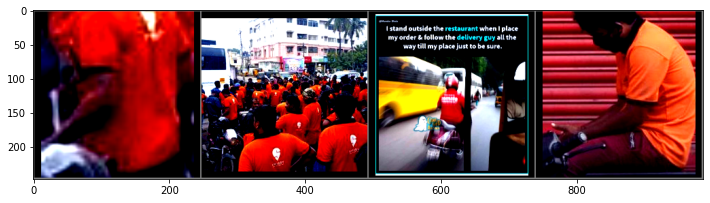

In [6]:
# load images and labels
train_iter = iter(dataloader['test'])
images, labels = train_iter.next()

# number of images in grid
n_images = 4

# make image grid
images_grid = torchvision.utils.make_grid(images[:n_images], nrow=4)

# un-normalize image
images_grid = images_grid / 2 + 0.5 

# plot images
plt.figure(figsize=(12,8))
plt.imshow(np.transpose(images_grid, (1, 2, 0)))

#print label for each image
print(" \t\t".join(str(label.tolist()) for label in labels[:4]))


## Model 

In [9]:
# check if gpu availabe
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("Using GPU")

### Model Architecture

In [8]:
class Network(nn.Module):
    "Multi label classification Network Class"
    
    def __init__(self, ):
        super().__init__()
        
        # conv layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        #Batch normalization layer
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        # max-pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        # dense layer
        self.fc1 = nn.Linear(15*15*128,1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 2)
        
        # batchnorm dense
        self.bc_fc1 = nn.BatchNorm1d(1024)
        self.bc_fc2 = nn.BatchNorm1d(128)
        
        # dropout
        self.dropout = nn.Dropout2d(p=.5)
        
    def forward(self, x):
        ## forward behavior 

        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))  
        x = self.bn3(self.pool(F.relu(self.conv3(x))))
        x = self.bn4(self.pool(F.relu(self.conv4(x))))
        x = self.dropout(x.view(x.shape[0], -1))
        
        
        x = self.dropout(self.bc_fc1(F.relu(self.fc1(x))))
        x = self.dropout(self.bc_fc2(F.relu(self.fc2(x))))
        x = F.sigmoid(self.fc3(x))
  
        return x

In [9]:
model_scratch = Network()

if use_cuda:
    model_scratch = model_scratch.cuda()
    
print(model_scratch)

Network(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (bc_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, a

In [10]:
# define optimizer and loss function
optimizer = optim.Adam(model_scratch.parameters())
criterion = nn.BCELoss()

In [62]:
def train(train_loader, val_loader, model, optimizer, criterion, n_epochs, path):
    """
    Function to train given model. It also save best fitted model
    Input: train_loader:: Dataloader for training
           val_loader:: DataLoader for validation
           model:: Model to train
           optimizer:: model optimizer
           criterion:: Loss function
           n_epochs :: Total number of training epochs
           save:: model save path with filename and extention
    Output: None
    """
    # min val loss
    min_val_loss = np.Inf
    
    for epoch in range(n_epochs):
        # for each epoch
        
        #train and val loss for every epoch
        train_loss = 0
        val_loss = 0
        
        # set model to train
        model.train()
        
        # train
        for batch_idx, (image, label) in enumerate(train_loader):
            
            if use_cuda:
                # if gpu avaliable transfer to gpu
                image, label = image.cuda(), label.cuda()
            
         
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output,label)
            
            loss.backward()
            optimizer.step()
            
            # cal loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        # set model to evaluate
        model.eval()
        
        # validate
        for batch_idx, (image, label) in enumerate(val_loader):
            # dont track gradient
            with torch.no_grad():
                
                if use_cuda:
                    image, label = image.cuda(), label.cuda()

                output = model(image)
                loss = criterion(output,label)
                val_loss += ((1 / (batch_idx + 1)) * (loss.data - val_loss))

    
        print("Epoch {} : \nTrain Loss : {:.2f}\t\t\t Val Loss : {:.2f}".format(epoch,train_loss,val_loss))
        
        
        if val_loss < min_val_loss:
            
            print('Model Saving')
            # better model
            min_val_loss = val_loss
            
            if use_cuda:    
                model = model.cpu()
                torch.save(model.state_dict(), path)
                model = model.cuda()
                continue
                
            torch.save(model.state_dict(), path)
    
    return None

In [12]:
# train model
save_path = '../data/model_scratch.brain'

train(dataloader['train'], dataloader['val'], model_scratch, optimizer, criterion, 10, save_path)

/home/ratnesh/.local/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 : 
Train Loss : 0.59			 Val Loss : 0.41
Model Saving
Epoch 1 : 
Train Loss : 0.48			 Val Loss : 0.53
Epoch 2 : 
Train Loss : 0.48			 Val Loss : 0.33
Model Saving
Epoch 3 : 
Train Loss : 0.42			 Val Loss : 0.31
Model Saving
Epoch 4 : 
Train Loss : 0.40			 Val Loss : 0.32
Epoch 5 : 
Train Loss : 0.39			 Val Loss : 0.30
Model Saving
Epoch 6 : 
Train Loss : 0.39			 Val Loss : 0.28
Model Saving
Epoch 7 : 
Train Loss : 0.37			 Val Loss : 0.25
Model Saving
Epoch 8 : 
Train Loss : 0.36			 Val Loss : 0.32
Epoch 9 : 
Train Loss : 0.35			 Val Loss : 0.25
Model Saving


In [59]:
def test(dataloader_test, model, creterion):
    model.eval()
    thrashhold = 0.75
    with torch.no_grad():
        human_pred, human_ = [], []
        swiggy_pred, swiggy_ = [], []
        
        test_loss = 0
        
        for batch_idx, (images, labels) in enumerate(dataloader_test):
            
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            
            output = model(images)
            
            loss = creterion(output, labels)
            
            human_pred.extend(output[:,0].round().type(torch.int32).tolist())
            swiggy_pred.extend(output[:,1].round().type(torch.int32).tolist())
            
            human_.extend(labels[:,0].type(torch.int32).tolist())
            swiggy_.extend(labels[:,1].type(torch.int32).tolist())
            
            test_loss += (1/(batch_idx+1)) * (loss.data - test_loss)
            
            
        human_f1  = f1_score(human_, human_pred)
        swiggy_f1 = f1_score(swiggy_, swiggy_pred)
        
        return test_loss, human_f1, swiggy_f1

In [16]:
#load best model
model_scratch.load_state_dict(torch.load('../data/model_scratch.brain'))

test_loss, human_acc, swiggy_acc = test(dataloader['test'], model_scratch, criterion)
print(f"""
Test Loss : {test_loss}

Human Accuracy : {human_acc}
Swiggy Accuracy : {swiggy_acc}

""")


Test Loss : 0.25252917408943176

Human Accuracy : 0.828125
Swiggy Accuracy : 0.8333333134651184




In [10]:
model = models.resnet101(pretrained=True)
fc = nn.Sequential(nn.Linear(2048,2), nn.Sigmoid())
model.fc = fc

if use_cuda:
    model = model.cuda()
    

In [11]:
# define optimizer and loss function
optimizer_transfer = optim.Adam(model.fc.parameters())
criterion = nn.BCELoss()

In [63]:
# train model
save_path = '../data/model_transfer.brain'

train(dataloader['train'], dataloader['val'], model, optimizer_transfer, criterion, 10, save_path)

Epoch 0 : 
Train Loss : 0.26			 Val Loss : 0.19
Model Saving
Epoch 1 : 
Train Loss : 0.22			 Val Loss : 0.18
Model Saving
Epoch 2 : 
Train Loss : 0.24			 Val Loss : 0.24
Epoch 3 : 
Train Loss : 0.21			 Val Loss : 0.11
Model Saving
Epoch 4 : 
Train Loss : 0.20			 Val Loss : 0.10
Model Saving
Epoch 5 : 
Train Loss : 0.19			 Val Loss : 0.14
Epoch 6 : 
Train Loss : 0.19			 Val Loss : 0.10
Epoch 7 : 
Train Loss : 0.19			 Val Loss : 0.11
Epoch 8 : 
Train Loss : 0.22			 Val Loss : 0.16
Epoch 9 : 
Train Loss : 0.16			 Val Loss : 0.09
Model Saving


In [64]:
#load best model
model.load_state_dict(torch.load('../data/model_transfer.brain'))

test_loss, human_acc, swiggy_acc = test(dataloader['test'], model, criterion)
print(f"""
Test Loss : {test_loss}

Human Accuracy : {human_acc}
Swiggy Accuracy : {swiggy_acc}

""")


Test Loss : 0.11146450787782669

Human Accuracy : 0.96875
Swiggy Accuracy : 0.9380530973451328


